# VaR and Credit Risk
## Value at Risk 

The value at risk (VaR) of a portfolio is a function of two parameters (time horizon and confidence level) and it is usually involved when it is important to know to a certain precentage of confidence ($X$) how much will be the maximum loss
in the next $N $days. It can be interpreted as the loss level over $N$ days that has a probability of only $(100 - X)\%$ of being exceeded.

Mathematically the VaR is the loss corresponding to the $(100-X)\textrm{th}$ precentile of the distribution of the change in the value of the portfolio over the next $N$ days.
For example, with $N=1$ and $X=95$, VaR is the fifth percentile of the distribution of changes in the value of the portfolio over the next day (e.g. in the next picture the graphical representation of the VaR assuming a normal distribution for the changes of value).

<img src="normal_curve.png">

VaR is useful to summarize all the information about the risk of a portfolio in one single number, but this can be also considered its main limitation (too much simplification).

Concerning the time horizon parameter it is usually set to $N=1$ since it is not easy to estimate market variables over periods longer than 1 day. To generalize the VaR estimate it is assumed:

$$\textrm{N-day VaR} = \textrm{1-day VaR}\times \sqrt{N}$$

This relation is true only if the value changes of the portfolio over the considered period of time have indipendent and identical normal distributions with mean 0 (otherwise it is just an approximation).

## How to Estimate the VaR

In the following examples we are going to use market data collected in [historical_data.csv](). As usual we can inspect and load this file with $\tt{pandas}$.

In [51]:
import pandas as pd
import numpy as np

w = np.array([0.6, 0.4])
df = pd.read_csv("quandl.csv")

aapl = df[df['ticker']=="AAPL"].copy() 
nflx = df[df['ticker']=="NFLX"].copy()

aapl['rets'] = aapl['adj_close']/aapl['adj_close'].shift(1) - 1 
nflx['rets'] = nflx['adj_close']/nflx['adj_close'].shift(1) - 1

print (aapl.head())

            date ticker  adj_close      rets
4201  2018-03-27   AAPL    168.340       NaN
4202  2018-03-26   AAPL    172.770  0.026316
4203  2018-03-23   AAPL    164.940 -0.045320
4204  2018-03-22   AAPL    168.845  0.023675
4205  2018-03-21   AAPL    171.270  0.014362


In the following we will assume to have a portfolio made of 60% of AAPL and 40% NFLX stocks.

### Historical Simulation
In order to estimate the VaR from an historical series, we need to collect the market variables affecting the portfolio over the last $N$ days (with $N$ quite large). 

The variation over each day in our time interval will provide different scenarios to be applied to today's market simulation so that for each of them we need to compute the variation in the portfolio value ($\Delta P$). Our VaR estimate will be the (100 - X)% percentile of the resulting distribution.
Given the 1-day VaR it is then possible to determine the N-day VaR using the above formula.

Of course such historical simulation relies on the assumption that past behaviors are indicative of what might happen in the future.

#### Example
Imagine a portfolio $P$ whose value depends only on two market variables ($x_1(t) , x_2(t)$). From the historical series of the market variables we can determine various *simulated* portfolio values:

$$P_i(t_n+1) = P\Big(x_1(t_n)\frac{x_1(t_i)}{x_1(t_{i-1})} , x_2(t_n)\frac{x_2(t_i)}{x_2(t_{i-1})}\Big)$$

Essentially rescaling the market variables according to the variation between day $i$ and $i-1$ we can draw a distribution of the possible changes in the portfolio value $P_i$ and then compute the VaR taking the appropriate percentile.

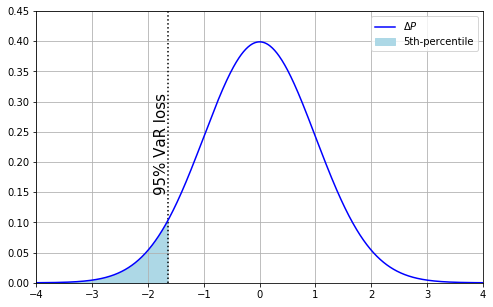

In [21]:
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy 

numpy.random.seed(1)
plt.figure(figsize=(8,5))
x = numpy.arange(-4,4,0.01)
xf = numpy.arange(-4, -1.64458, 0.01)
plt.plot(x, norm.pdf(x), color="blue", label="$\Delta P$")
plt.fill_between(xf, 0, norm.pdf(xf), color="lightblue", label="5th-percentile")
plt.vlines(-1.64458, 0, 0.45, color="black", linestyle=":")
plt.text(-1.9, 0.15, "95% VaR loss", rotation=90, fontsize=15)
plt.ylim(0, 0.45)
plt.xlim(-4, 4)
plt.grid(True)
plt.legend()
plt.show()

Historical VAR is -2.412


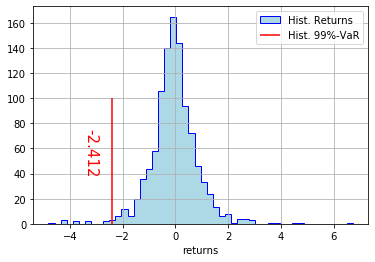

In [52]:
# historical VaR
from scipy.stats import norm

rets = []
for i in range(1, len(aapl)):
    rets.append(w[0]*aapl.iloc[i]['rets'] + w[1]*nflx.loc[i]['rets'])

price = [aapl.iloc[-1]['adj_close'], nflx.iloc[-1]['adj_close']]

portfolio_price = w.dot(price)

hist_var = portfolio_price*np.percentile(rets, 1)
print ('Historical VAR is {:.3f}'.format(hist_var))

dP = [r*portfolio_price for r in rets]
plt.hist(dP, 50, color="lightblue", edgecolor="blue", 
         histtype="stepfilled", label="Hist. Returns")
plt.vlines(hist_var, 0, 100, color="red", label="Hist. 99%-VaR")
plt.text(-3.5, 40, "{:.3f}".format(hist_var), color='red', 
         rotation=-90, fontsize=15)
plt.grid(True)
plt.xlabel("returns")
plt.legend()
plt.show()

### Model Approach
Our portfolio P consists of different amounts wi invested on two assets. If with ∆xi we denote the daily return of the ith asset the change in the value of the portfolio can be expressed as:

$$\Delta P = \sum_{i=1}^n a_i \Delta x_i$$

If we then assume that the asset variations are normally distributed with mean 0 (in this ap- proach is typical to assume the expected change in a market variable over the considered period zero), ∆P will be normally distributed (as a sum of normal distribution) with zero mean.
To estimate the VaR we just need to compute the standard deviation of ∆P. In the general case with many different assets we define σi the daily volatility of the ith asset and with ρij the correlation coefficient between the assets i and j. The variance of ∆P can then be expressed as:


$$\begin{align*}\sigma^2_P & = \sum_{i=1}^{n}\sum_{j=1}^{n}\rho_{ij}a_i a_j \sigma_i \sigma_j \\
& = \sum_{i=1}^{n} a_i^2 \sigma_i^2 + 2 \sum_{i=1}^{n}\sum_{j<i}^{n}\rho_{ij}a_i a_j \sigma_i \sigma_j \end{align*}$$

As in the previous case if we are interested in a longer time horizon we can use Eq. 13.1.
Once we have the variance of ∆P it is easy to determine the appropriate percentile using the equations described in Appendix B.6.


### Monte Carlo Simulation
A very useful alternative to the previous approaches is using a Monte Carlo simulation to generate the probability distribution for the $\Delta P$ distribution.

Imagine we need to compute the 1-day VaR for our example portfolio the simulation can be done either generating random returns from a distribution with mean and standard deviation obtained from the historical data of each stock, or by simulating the evolution of all the portfolio market variables in one day.

Let’s start from the first case, computing mean and standard deviation of each historical data- set. We will then throw various simulated returns from a multivariate Gaussian with such means and variances. One useful aspect of this method is that in principal other distribution could be used instead of a Gaussian. Once we have the distribution of returns the VaR can be computed as usual.

Simulated VAR is -2.115


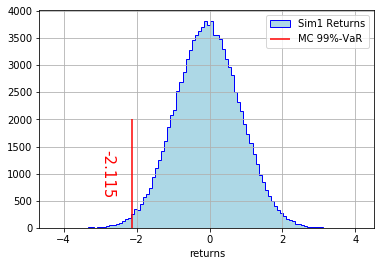

In [55]:
# MC simulated VaR 1

from scipy.stats import multivariate_normal

mean = [np.mean(aapl['rets']), np.mean(nflx['rets'])]
std = [np.std(aapl['rets']), np.std(nflx['rets'])]

mvnorm = multivariate_normal(mean=mean, cov=[[std[0]**2, 0],
                                             [0, std[1]**2]])
np.random.seed(1)
n_sims = 100000
sim_returns = mvnorm.rvs(n_sims)
p_returns = [w.dot(s) for s in sim_returns]
mc_var = portfolio_price * np.percentile(p_returns, 1)
print('Simulated VAR is {:.3f}'.format(mc_var))

dP = [r*portfolio_price for r in p_returns]
plt.hist(dP, 100, color="lightblue", edgecolor="blue", 
         histtype="stepfilled", label="Sim1 Returns")
plt.vlines(mc_var, 0, 2000, color="red", label="MC 99%-VaR")
plt.text(-3., 600, "{:.3f}".format(mc_var), color='red', 
         rotation=-90, fontsize=15)
plt.grid(True)
plt.xlabel("returns")
plt.legend()
plt.show()

This result can be compared with the VaR estimated with a simulation of the daily evolution of the stock price. We will use the log-normal evolution described in Section 8.5 where μ and σ@ are the mean and variance estimated from the historical series. 

Simulated VAR is -1.923


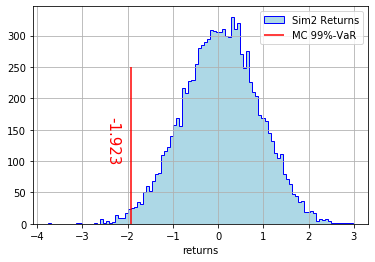

In [66]:
from numpy.random import normal
from numpy import exp, sqrt

T = 1
trials = 10000
dP = []

for _ in range(trials):
    s = 0
    for i in range(2):
        s += w[i] * price[i] * exp((mean[i] - 0.5 * std[i]**2) * T + 
                                   std[i] * sqrt(T) * normal())
    dP.append(portfolio_price - s)
    
mc_var2 = np.percentile(dP, 1)
print('Simulated VAR is {:.3f}'.format(mc_var2))

plt.hist(dP, 100, color="lightblue", edgecolor="blue", 
         histtype="stepfilled", label="Sim2 Returns")
plt.vlines(mc_var2, 0, 250, color="red", label="MC 99%-VaR")
plt.text(-2.5, 100, "{:.3f}".format(mc_var2), color='red', 
         rotation=-90, fontsize=15)
plt.grid(True)
plt.xlabel("returns")
plt.legend()
plt.show()

### Stress Testing and Back Testing
In addition to calculating VaR, it can be useful to perform a *stress test*. This essentially implies to estimate how a portfolio would behave under the most extreme market moves seen in the last years.

From the historical series are taken the market variables seen in particular days with exceptional large variations. The idea is to take into account extreme events that can occur but that have such low probability that are hard to simulate (e.g. a 5-standard deviation move should happen once every 7000 years but in practice can be observed twice over 10 years.

In [67]:
from scipy.stats import norm

prob = norm.cdf(-5) * 2 # since I'm fine with +- 5sigma movements
nyears = (1/prob) / 252 # number of days for 1 event / working days 
print ("Expect one 5-sigma event every {:.0f} years".format(nyears))

Expect one 5-sigma event every 6922 years


Another important check that could be done is the so-called back testing which consists of checking how well the VaR estimate would have performed in the past. Basically it has to be tested how often the daily loss exceeded the N-days X% VaR just computed. If it happens on about (100-X)% of the times we can be confident that our estimate is correct.

## Credit Var (Cr-Var)
The Credit-VaR is a measure of the default risk associated to one or multiple counterparties in a specific portfolio, and it is defined on the overall exposure to all the counterparties involved. Cr-VaR is defined in the usual way Value at Risk measures are defined (i.e. as percentile of a loss). Our exposure Ex at the default date is defined as:
Ex = (∑Π(τ,T))+
where Π(τ, T) represents the discounted cash flows at the default date τ; the corresponding
loss is then given by:
Lτ,Tˆ,T =(1−R)·Ex(τ)
where T is the risk horizon and L is non-zero only in scenarios of early default of the counter-
party. Given the above definitions we can express the Cr-VaR as the q-quantile of Lτ,Tˆ,T.

In [76]:
from scipy.stats import norm
from math import sqrt

X = 0.999
rho = 0.1
R = 0.6
DP = 0.02
exposure = 100e6

num = norm.ppf(DP) + sqrt(rho)*norm.ppf(X)
den = sqrt(1-rho)
V = norm.cdf(num/den)

cr_var = exposure*V*(1-R)
print ("Cr-VaR: {:.0f}".format(round(cr_var, -4)))

Cr-VaR: 5130000


In [130]:
from scipy.stats import multivariate_normal, norm
import numpy

# AAA, AA, A, BBB, BB, B, CCC, Def
table = [[90.81, 8.33, 0.68, 0.06, 0.08, 0.02, 0.01, 0.01],
         [0.70, 90.65, 7.79, 0.64, 0.06, 0.13, 0.02, 0.01],
         [0.09, 2.27, 91.05, 5.52, 0.74, 0.26, 0.01, 0.06],
         [0.02, 0.33, 5.95, 85.93, 5.30, 1.17, 1.12, 0.18],
         [0.03, 0.14, 0.67, 7.73, 80.53, 8.84, 1.00, 1.06],
         [0.01, 0.11, 0.24, 0.43, 6.48, 83.46, 4.07, 5.20],
         [0.21, 0, 0.22, 1.30, 2.38, 11.24, 64.86, 19.79]]

table_gauss = []

for i in range(len(table)):
    temp = []
    s = 0
    for j in range(8):
        s += table[i][j]/100
        if s>1:
            s = 1
        temp.append(norm.ppf(s))
    table_gauss.append(temp)
    
N = [100, 95, 92, 85, 80, 70, 60]
portfolio = [2, 3, 3, 4, 5, 6, 3, 4, 2]
R = 0.4

# A, BB, B
p0 = 0
for i in portfolio:
    p0 += N[i]
    
mvnorm = multivariate_normal(mean=[0 for _ in range(9)], 
                             cov=[[1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1]])

trials = 100000
x_prob = mvnorm.rvs(size=trials)

dp = []
for i in range(len(x_prob)):
    p = 0
    for j in range(9):
        ip = 0
        while x_prob[i][j] > table_gauss[portfolio[j]][ip]:
            ip += 1
        if ip == 7:
            p += N[portfolio[j]]*(1-R)
        else:
            p += N[ip]
    r = max(0, -(p - p0))
    if r != 0:
        dp.append(r)

crvar = numpy.percentile(dp, [99.9])
print (crvar)

[124.]


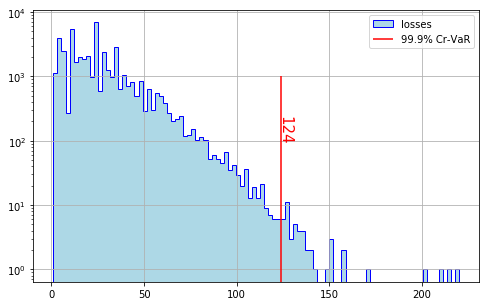

In [131]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(dp, 100, color='lightblue', edgecolor='blue', histtype='stepfilled', label="losses")
plt.yscale("log")
plt.vlines(crvar[0], 0, 1000, color="red", label="99.9% Cr-VaR")
plt.text(122, 100, "{:.0f}".format(crvar[0]), color='red', 
         rotation=-90, fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

## Credit Valuation Adjustment

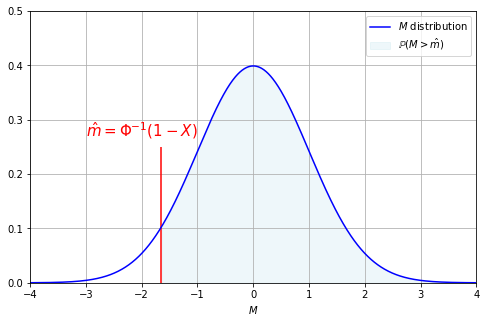

In [158]:
from scipy.stats import norm
import numpy
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
X = 0.95
x = numpy.arange(-4, 4, 0.01)
plt.plot(x, norm.pdf(x), color='blue', label="$M$ distribution")
v = norm.ppf(1-0.95)
xv = numpy.arange(v, 4, 0.01)
plt.fill_between(xv, 0, norm.pdf(xv), color='lightblue', alpha=0.2, label="$\mathbb{P}(M>\hat{m})$")
plt.vlines(v, 0, 0.25, color='red')
plt.text(-3, 0.27, "$\hat{m} = \Phi^{-1}(1-X)$", color='red', fontsize=15)
plt.xlim(-4, 4)
plt.ylim(0, 0.5)
plt.grid(True)
plt.xlabel("$M$")
plt.legend()
plt.show()

